# Random Forest - Consumo Doméstico de Energia

Modelo de floresta aleatória com engenharia de features temporais, validação temporal e tuning de hiperparâmetros.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os, json, warnings
warnings.filterwarnings('ignore')

# Output
output_dir = '../../out/household_consumption/RandomForest'
os.makedirs(output_dir, exist_ok=True)

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize']=(12,6)
sns.set_palette('husl')

In [2]:
# Carregar dados
data_path='../../data/household_consumption.xlsx'
df = pd.read_excel(data_path, sheet_name='Sheet1')
df['Date and Hour']=pd.to_datetime(df['Date and Hour'])
df=df.set_index('Date and Hour').sort_index().dropna()
print(df.head())
print('Período:', df.index.min(),'->',df.index.max(),'Freq:',pd.infer_freq(df.index))

                     Consumption
Date and Hour                   
2006-12-16 16:24:00        4.216
2006-12-16 16:25:00        5.360
2006-12-16 16:26:00        5.374
2006-12-16 16:27:00        5.388
2006-12-16 16:28:00        3.666
Período: 2006-12-16 16:24:00 -> 2006-12-20 03:43:00 Freq: min


In [3]:
# Feature engineering
def create_features(data, n_lags=24):
    X = pd.DataFrame(index=data.index)
    y = data['Consumption']
    for i in range(1, n_lags+1):
        X[f'lag_{i}']=y.shift(i)
    for w in [3,6,12,24,48,96]:
        X[f'roll_mean_{w}']=y.rolling(w).mean()
        X[f'roll_std_{w}']=y.rolling(w).std()
    X['hour']=data.index.hour
    X['dow']=data.index.dayofweek
    X['month']=data.index.month
    X['hour_sin']=np.sin(2*np.pi*X['hour']/24)
    X['hour_cos']=np.cos(2*np.pi*X['hour']/24)
    X['dow_sin']=np.sin(2*np.pi*X['dow']/7)
    X['dow_cos']=np.cos(2*np.pi*X['dow']/7)
    return X, y

X, y = create_features(df, n_lags=36)
data = pd.concat([X,y.rename('target')], axis=1).dropna()
X, y = data.drop('target',axis=1), data['target']

train_size = int(len(X)*0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [4]:
# Grid Search
param_grid={
  'n_estimators':[200,400],
  'max_depth':[10,20,None],
  'min_samples_split':[2,5],
  'min_samples_leaf':[1,2]
}
rf=RandomForestRegressor(random_state=42,n_jobs=-1)
tscv=TimeSeriesSplit(n_splits=5)
grid=GridSearchCV(rf,param_grid,cv=tscv,scoring='neg_mean_squared_error',n_jobs=-1,verbose=1)
sample=min(10000,len(X_train_s))
grid.fit(X_train_s[:sample], y_train.iloc[:sample])
print('Best params:',grid.best_params_)
print('Best CV MSE:',-grid.best_score_)
best_rf=grid.best_estimator_
best_rf.fit(X_train_s,y_train)
y_pred=best_rf.predict(X_test_s)

mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
mae=mean_absolute_error(y_test,y_pred)
mape=np.mean(np.abs((y_test-y_pred)/y_test))*100
r2=r2_score(y_test,y_pred)
print('RMSE:',rmse,'MAE:',mae,'MAPE:',mape,'R2:',r2)

# Salvar resultados
res={'model':'RandomForest','best_params':grid.best_params_,'metrics':{'mse':float(mse),'rmse':float(rmse),'mae':float(mae),'mape':float(mape),'r2':float(r2)},'n_features':X.shape[1],'train':len(X_train),'test':len(X_test)}
json.dump(res, open(f'{output_dir}/rf_results.json','w'), indent=2)
pd.DataFrame({'real':y_test,'pred':y_pred}, index=y_test.index).to_csv(f'{output_dir}/rf_predictions.csv')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV MSE: 0.12131696911035077
Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV MSE: 0.12131696911035077
RMSE: 0.12008681621790583 MAE: 0.05469041351493518 MAPE: 5.245968349645475 R2: 0.9838588276392242
RMSE: 0.12008681621790583 MAE: 0.05469041351493518 MAPE: 5.245968349645475 R2: 0.9838588276392242


roll_mean_3    0.911033
lag_2          0.033885
roll_std_3     0.023605
lag_1          0.007139
lag_5          0.006425
roll_mean_6    0.004911
roll_std_12    0.001369
roll_std_6     0.000986
roll_std_48    0.000799
lag_3          0.000683
roll_std_24    0.000531
lag_35         0.000483
roll_std_96    0.000419
lag_4          0.000336
lag_17         0.000332
dtype: float64


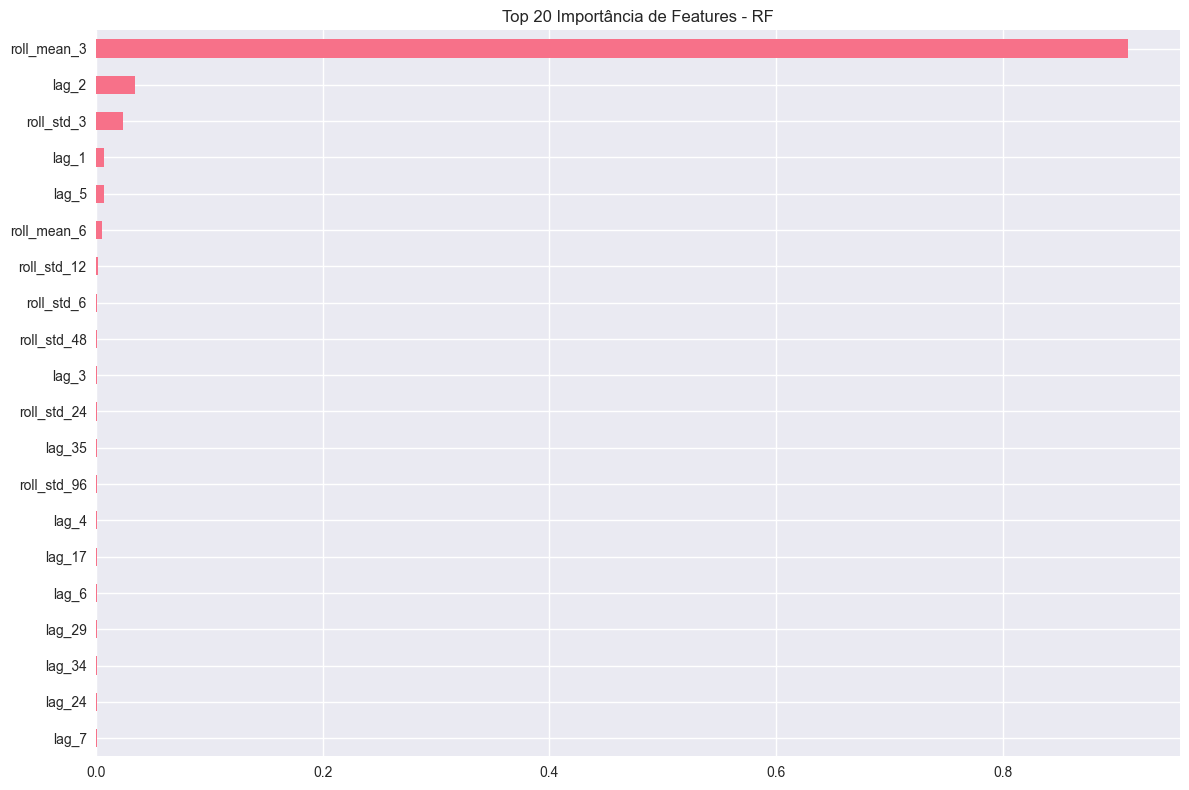

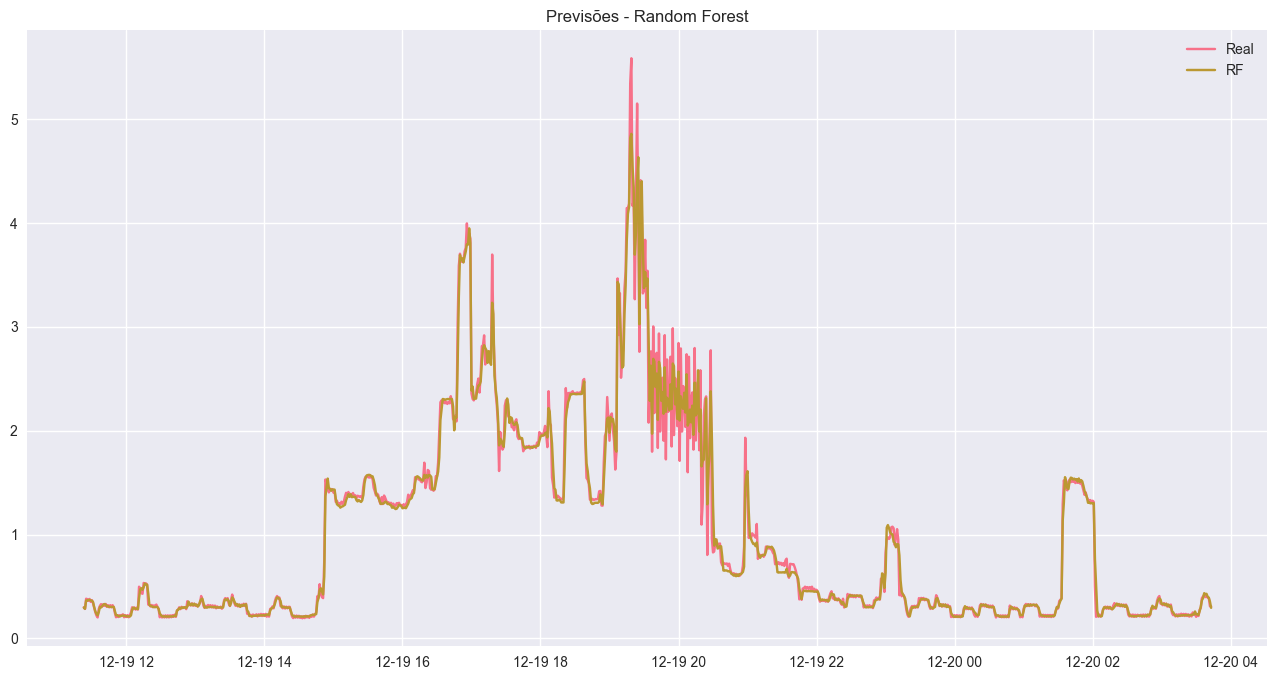

In [5]:
# Importância de features
importances = best_rf.feature_importances_
fi = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(fi.head(15))
fi.to_csv(f'{output_dir}/rf_feature_importance.csv')
plt.figure(figsize=(12,8))
fi.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 20 Importância de Features - RF')
plt.tight_layout()
plt.savefig(f'{output_dir}/rf_feature_importance.png', dpi=300)
plt.show()

# Plot previsões
plt.figure(figsize=(16,8))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, y_pred, label='RF')
plt.legend(); plt.title('Previsões - Random Forest')
plt.savefig(f'{output_dir}/rf_predictions.png', dpi=300)
plt.show()